In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("drive/MyDrive/data.csv")
# just drag and drop the file into collab!

# Text Preprocessing

In [6]:
#Utility functions designed to perform the following tasks on a given text description:
# eliminate non-ASCII characters, convert to lowercase, remove stop words, HTML tags, and punctuation.

def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [9]:
df['Desc'] = df['Desc'].astype(str)

df['cleaned'] = df['Desc'].apply(_removeNonAscii)

df['cleaned'] = df.cleaned.apply(func = make_lower_case)
df['cleaned'] = df.cleaned.apply(func = remove_stop_words)
df['cleaned'] = df.cleaned.apply(func=remove_punctuation)
df['cleaned'] = df.cleaned.apply(func=remove_html)


# Building Average Word2Vec Model

In [10]:
EMBEDDING_FILE = 'drive/MyDrive/GoogleNews-vectors-negative300.bin'
# warning, you need to download this file (3gig), contains vectors of length 300 for embedding words


In [11]:
#break description into words

i = 0
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

for i, sentence in enumerate(corpus[:5]):
    print(f"Line {i+1}: {sentence}")


Line 1: ['know', 'power', 'shifting', 'west', 'east', 'north', 'south', 'presidential', 'palaces', 'public', 'squares', 'formidable', 'corporate', 'behemoths', 'nimble', 'startups', 'and', 'slowly', 'surely', 'men', 'women', 'power', 'merely', 'shifting', 'dispersing', 'also', 'decaying', 'power', 'today', 'constrained', 'risk', 'losing', 'ever', 'before', 'end', 'power', 'award', 'winning', 'columnist', 'former', 'foreign', 'policy', 'editor', 'moiss', 'nam', 'illuminates', 'struggle', 'once', 'dominant', 'megaplayers', 'new', 'micropowers', 'challenging', 'every', 'field', 'human', 'endeavor', 'drawing', 'provocative', 'original', 'research', 'nam', 'shows', 'antiestablishment', 'drive', 'micropowers', 'topple', 'tyrants', 'dislodge', 'monopolies', 'open', 'remarkable', 'new', 'opportunities', 'also', 'lead', 'chaos', 'paralysis', 'nam', 'deftly', 'covers', 'seismic', 'changes', 'underway', 'business', 'religion', 'education', 'within', 'families', 'matters', 'war', 'peace', 'example

In [12]:
#when running with available memory, set workers > 0 !!!

from gensim.models import Word2Vec, KeyedVectors

# train corpus with Google pretrained model
google_model = Word2Vec(vector_size=300, window=5, min_count=2, workers=-1)
google_model.build_vocab(corpus)

# load pretrained word vectors using keyedVectors
word_vectors = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

google_model.corpus_count = len(corpus)

google_model.wv.add_vectors(keys=word_vectors.index_to_key, weights=word_vectors.vectors)

In [13]:
google_model.train(corpus, total_examples=google_model.corpus_count, epochs=5)

(0, 0)

In [14]:
#test the model with any word you like
google_model.wv.most_similar(positive=["computer"])

[('Kvapil', 0.27701327204704285),
 ('Whelen', 0.2619367241859436),
 ('Insana', 0.2579900324344635),
 ('Doran_Racing', 0.2562899589538574),
 ('SqueezeTrigger.com_Tel_+1', 0.251951664686203),
 ('Bertolino', 0.24864928424358368),
 ('Almirola', 0.24829015135765076),
 ('Emporia_Kan.', 0.2469758689403534),
 ('MIKE_FORD', 0.24251411855220795),
 ('Trenkle', 0.2423706352710724)]

In [15]:
google_model.wv.most_similar(positive=["symbol"])

[('centerfold', 0.30821385979652405),
 ('Model_Doutzen_Kroes', 0.2916649878025055),
 ('bamboo_floors', 0.2754090428352356),
 ('bottle_wine_cellar', 0.27357247471809387),
 ('Tracy_Turnblad', 0.27090781927108765),
 ('marching_downfield', 0.26821818947792053),
 ('Esti_Ginzburg', 0.26804980635643005),
 ('orphan_GPCRs', 0.2675970792770386),
 ('Hardwood_floors', 0.2643381655216217),
 ('monokini', 0.2566744089126587)]

In [17]:
def vectors2(x):
    # store all of the vectors in the following list
    global word_embeddings
    word_embeddings = []

    # read book descriptions
    for line in df['cleaned']:
        avgword2vec = None
        count = 0
        for word in line.split():
          # Check word is in vocab
            if word in google_model.wv.key_to_index:
                count += 1
                if avgword2vec is None:
                    avgword2vec = google_model.wv.get_vector(word)
                else:
                    avgword2vec = avgword2vec + google_model.wv.get_vector(word)

        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
            word_embeddings.append(avgword2vec)


In [19]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# assuming df is your DataFrame and array_embeddings is your array of word embeddings

def recommendations2(title):

    #begin scanning book descs and pass them into vectors
    vectors2(df)

    # cosine similarity between vectors
    cosine_similarities = cosine_similarity(word_embeddings, word_embeddings)

    # for each book, grab title and image url
    books = df[['title', 'image_link']]

    # grab the index using mapping
    indices = pd.Series(df.index, index=df['title']).drop_duplicates()

    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]

    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['title'])





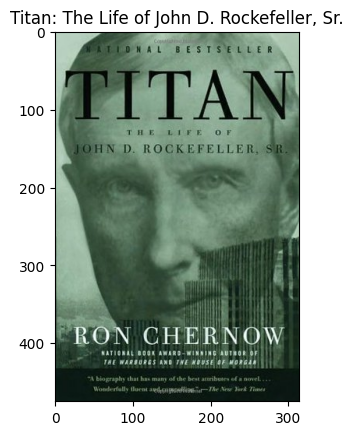

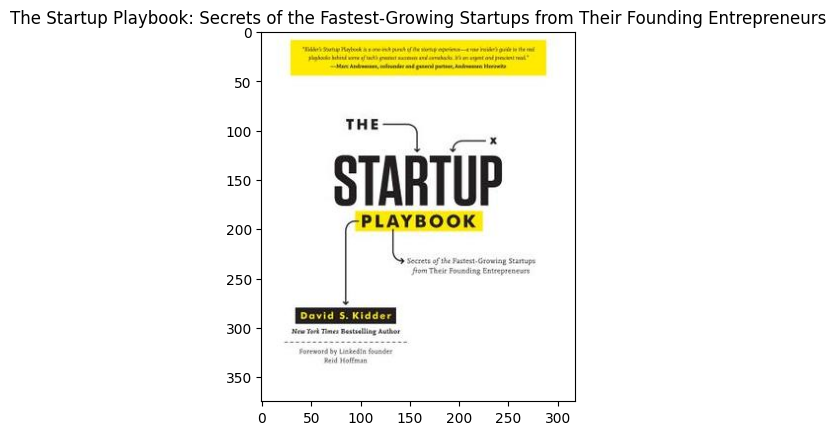

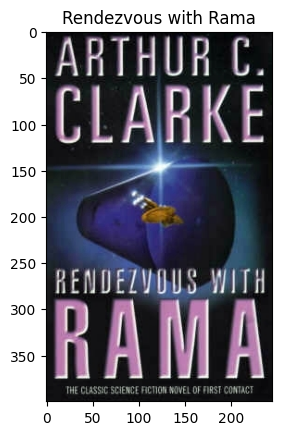

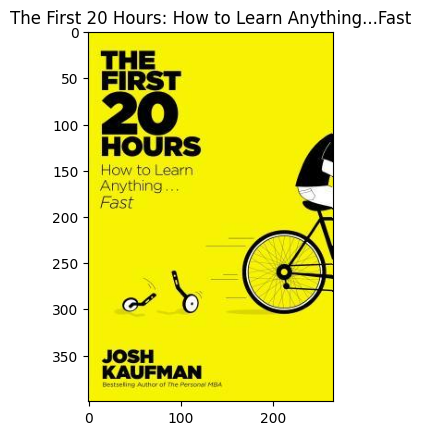

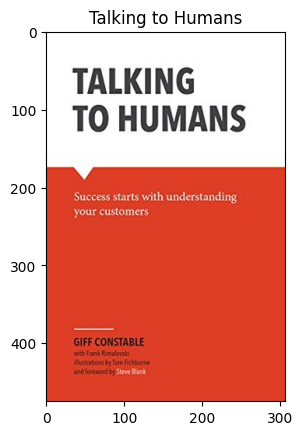

In [20]:
# test reccomendation with a book title
recommendations2("Steve Jobs")

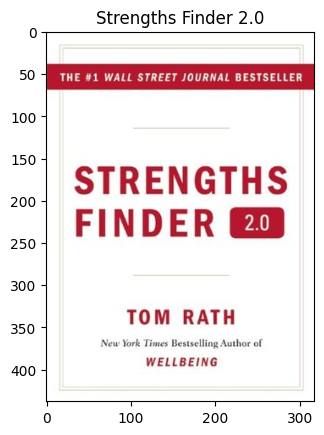

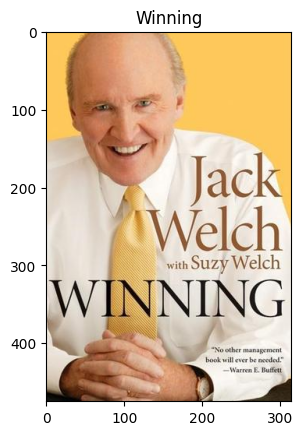

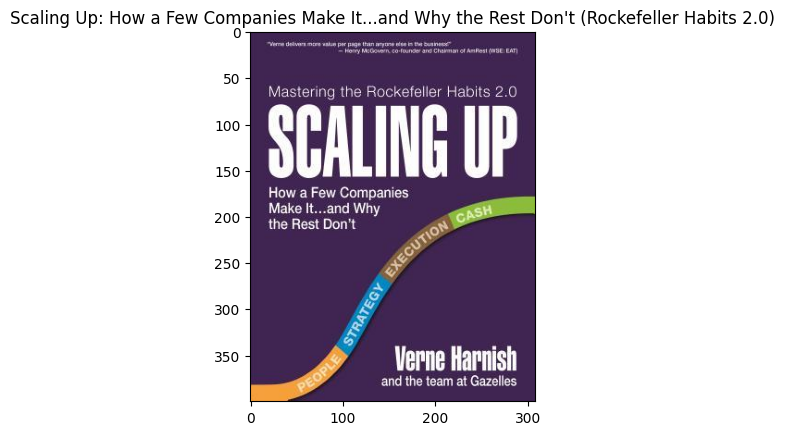

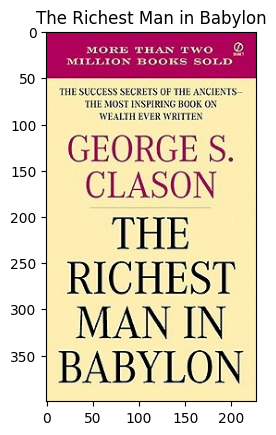

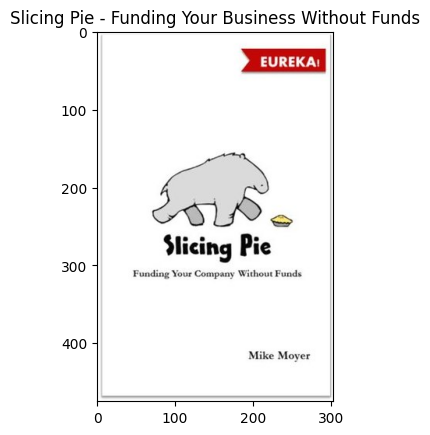

In [21]:

recommendations2("Aesop's Fables")

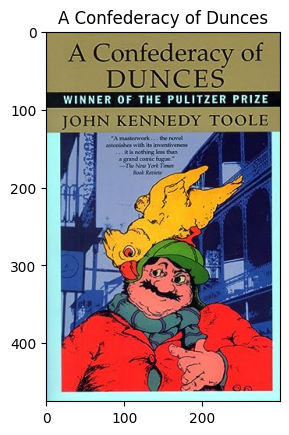

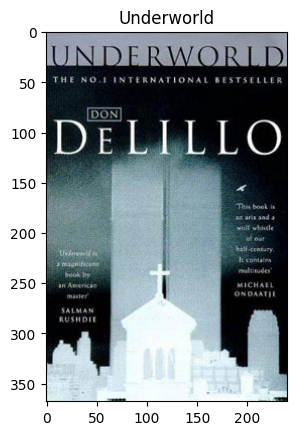

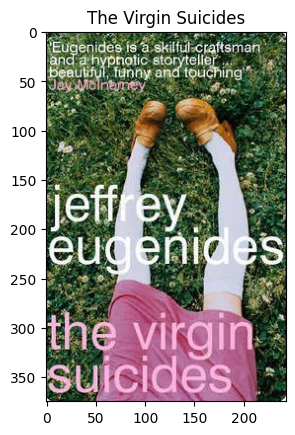

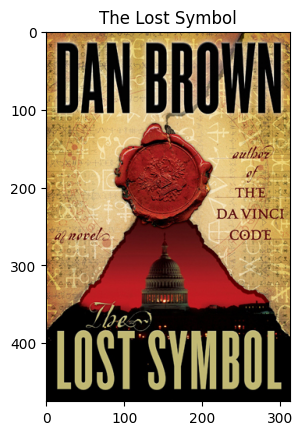

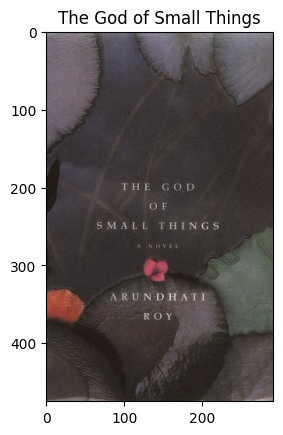

In [22]:
recommendations2("The Da Vinci Code")

# TF-IDF Word2Vec:

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=5, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['cleaned'])

# grab words in TF-IDF model
tfidf_feature = tfidf.get_feature_names_out()

# build a dict with feature names and corresponding scores
tfidf_list = dict(zip(tfidf_feature, tfidf.idf_))


In [25]:
# construct TF-IDF Word2Vec


tfidf_vectors = [];
line = 0;
# for each book description
for desc in corpus:

    sent_vec = np.zeros(300)
    weight_sum =0;
    # for each word in the book description
    for word in desc:
      if word in google_model.wv.key_to_index and word in tfidf_feature:
          vec = google_model.wv[word]
          tf_idf = tfidf_list[word] * (desc.count(word) / len(desc))
          sent_vec += (vec * tf_idf)
          weight_sum += tf_idf

    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    line += 1

In [26]:
#find the first 5 similar books

def recommendations(title):

    #cosine similarity between vectors

    cosine_similarities = cosine_similarity(tfidf_vectors,  tfidf_vectors)

    # image and book stored
    books = df[['title', 'image_link']]
    #grab index
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()

    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]
    for index, row in recommend.iterrows():

        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['title'])

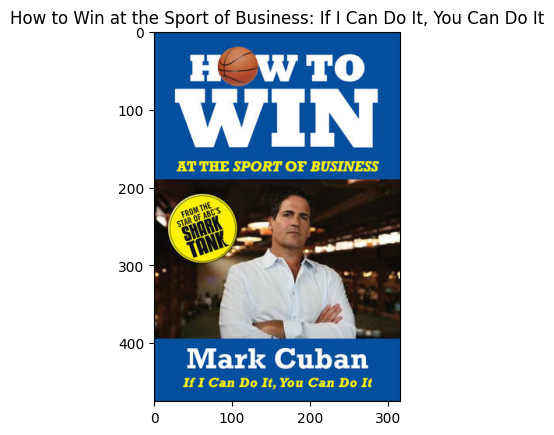

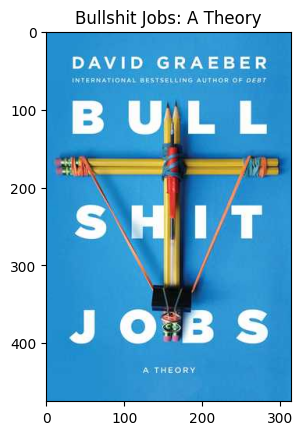

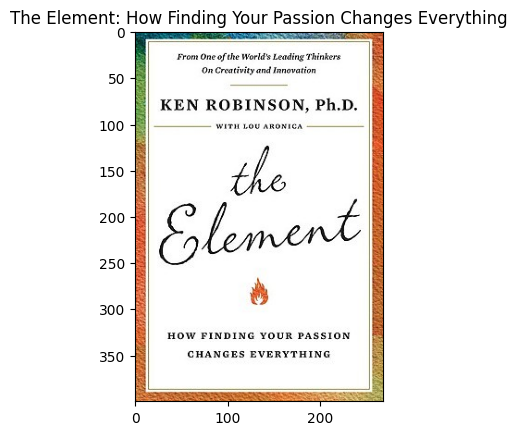

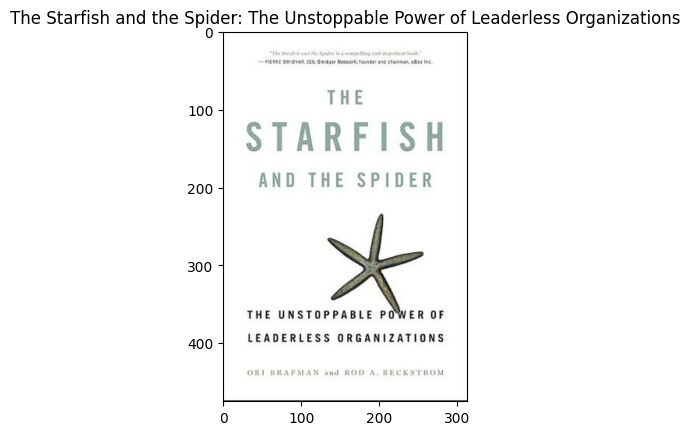

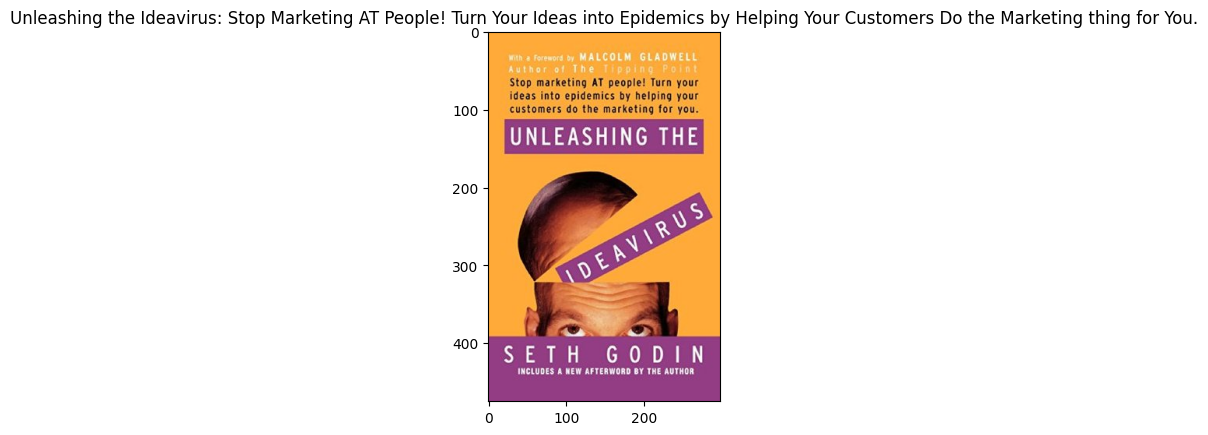

In [27]:
recommendations("Steve Jobs")

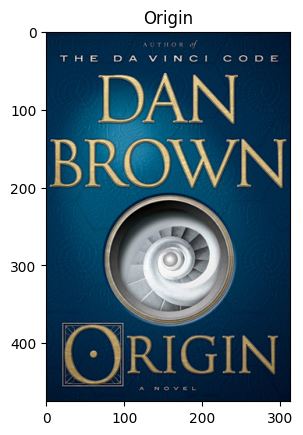

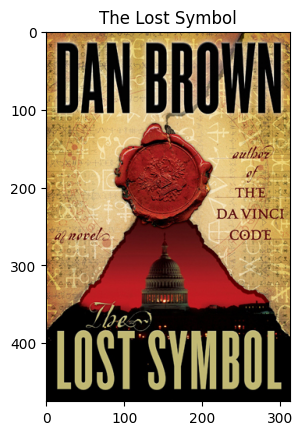

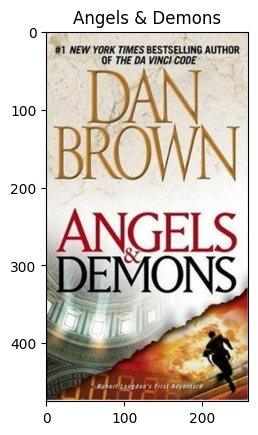

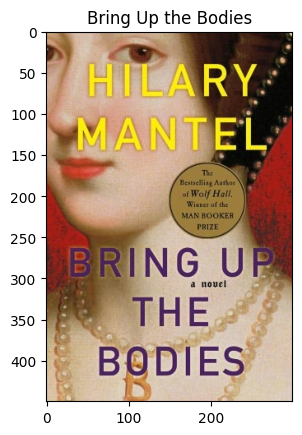

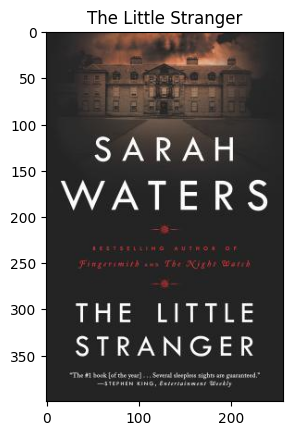

In [28]:
recommendations("The Da Vinci Code")

<Axes: >

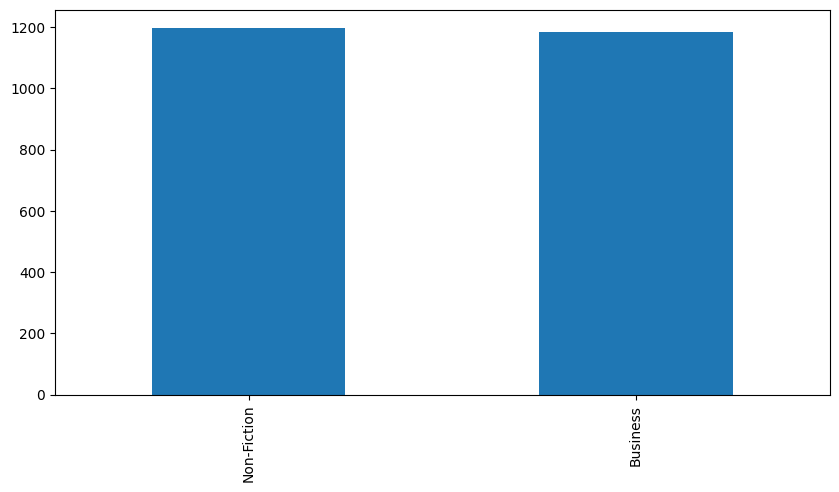

In [28]:
################################################################
###############################################################

# Importing necessary libraries
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

# read file
df = pd.read_csv("drive/MyDrive/data.csv")

#check 5 records
df.head()

# plot genre graph
df['genre'].value_counts().plot(x = 'genre', y ='count', kind = 'bar', figsize = (10,5)  )


The Now Habit: A Strategic Program for Overcoming Procrastination and Enjoying Guilt-Free Play


<Axes: title={'center': 'Word Count Distribution per Book Summary'}, ylabel='Frequency'>

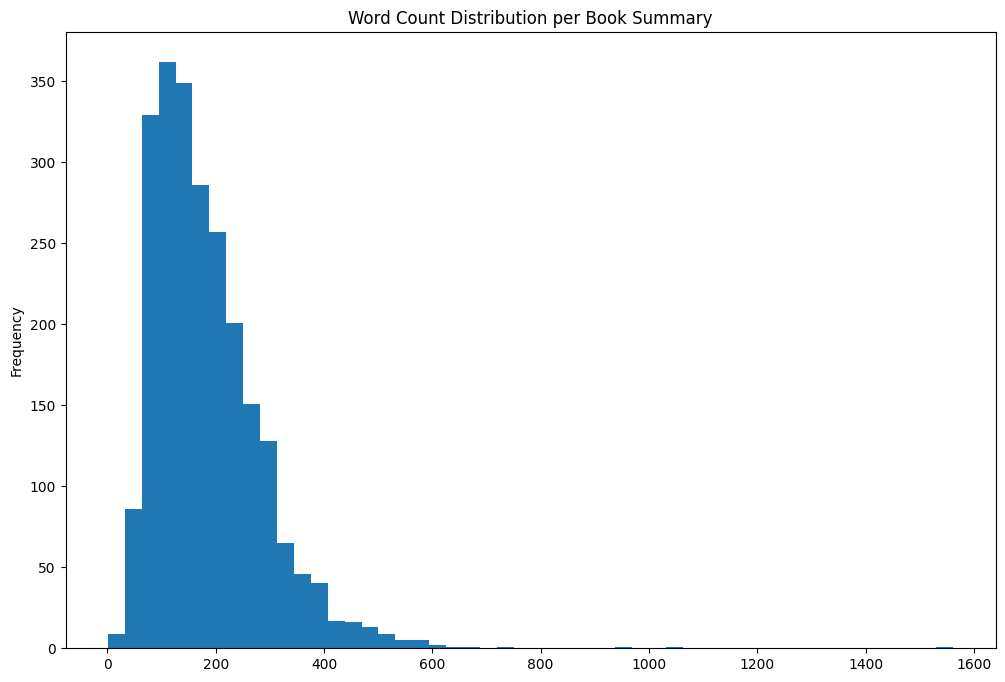

In [30]:
# display a book and description
print(df['title'] [110])
df['Desc'][110]

# total up word count distributions
df['word_count'] = df['Desc'].apply(lambda x: len(str(x).split()))
df['word_count'].plot(
    kind='hist',
    bins = 50,
    figsize = (12,8),title='Word Count Distribution per Book Summary')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<Axes: title={'center': 'Parts of Speed Frequency per Summary'}>

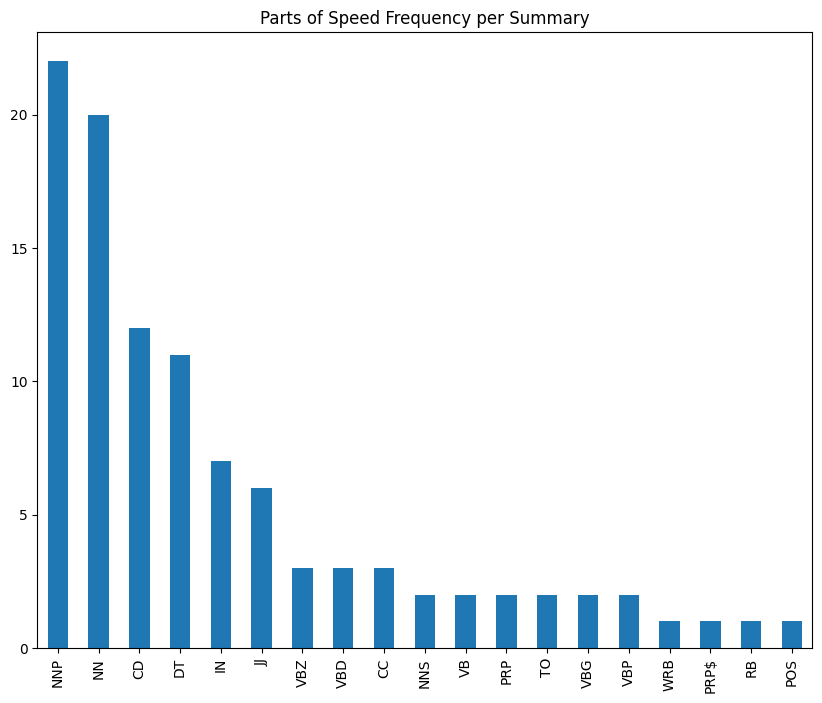

In [32]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from textblob import TextBlob
blob = TextBlob(str(df['Desc']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.plot(kind = 'bar', figsize=(10, 8), title = "Parts of Speech Frequency")

<Axes: title={'center': 'Bigram disribution for the top 20 words in the book description'}, xlabel='bigram'>

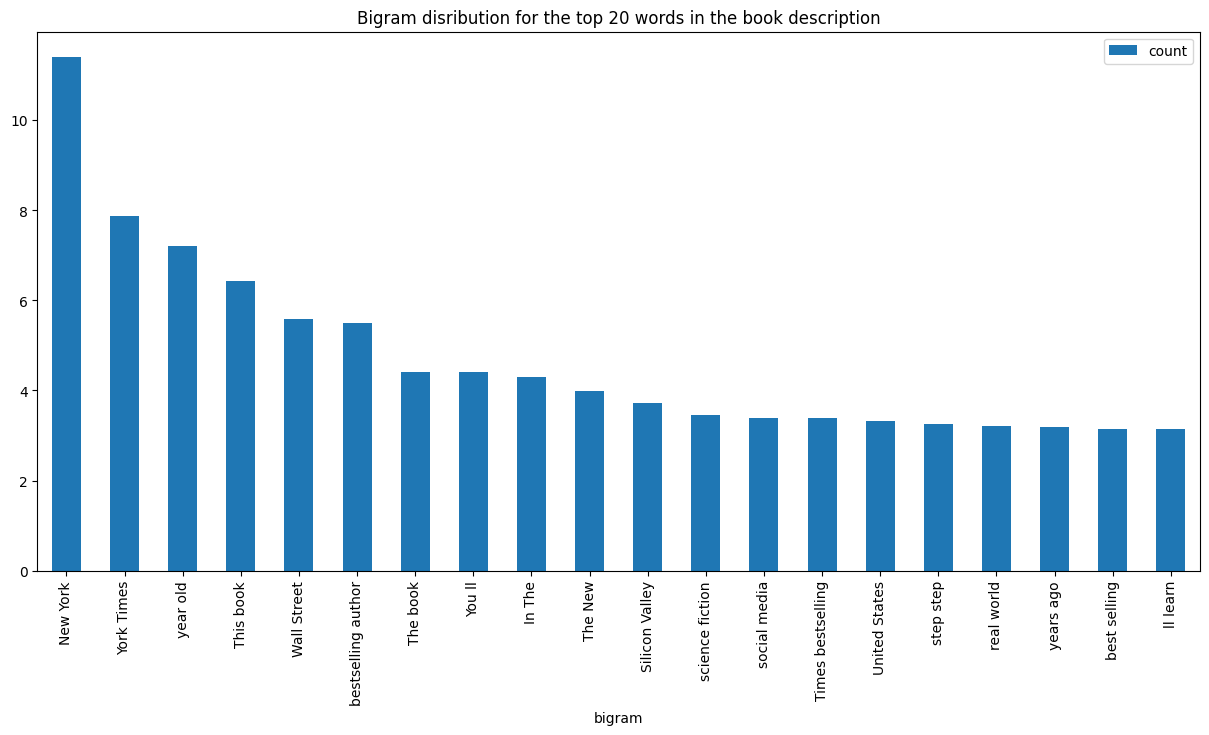

In [33]:
#Converting summary into Vector using Bigrams
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(df['Desc'])
total_words = tfidf_matrix.sum(axis=0)
# word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)
#ake a  dataframe from freq
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True)
#grabbing only the first 20
bigram = bigram.head(20)

#show bigram distribution
bigram.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution over book description", figsize = (15,7), )

<Axes: title={'center': 'Bigram disribution for the top 20 words in the book description'}, xlabel='trigram'>

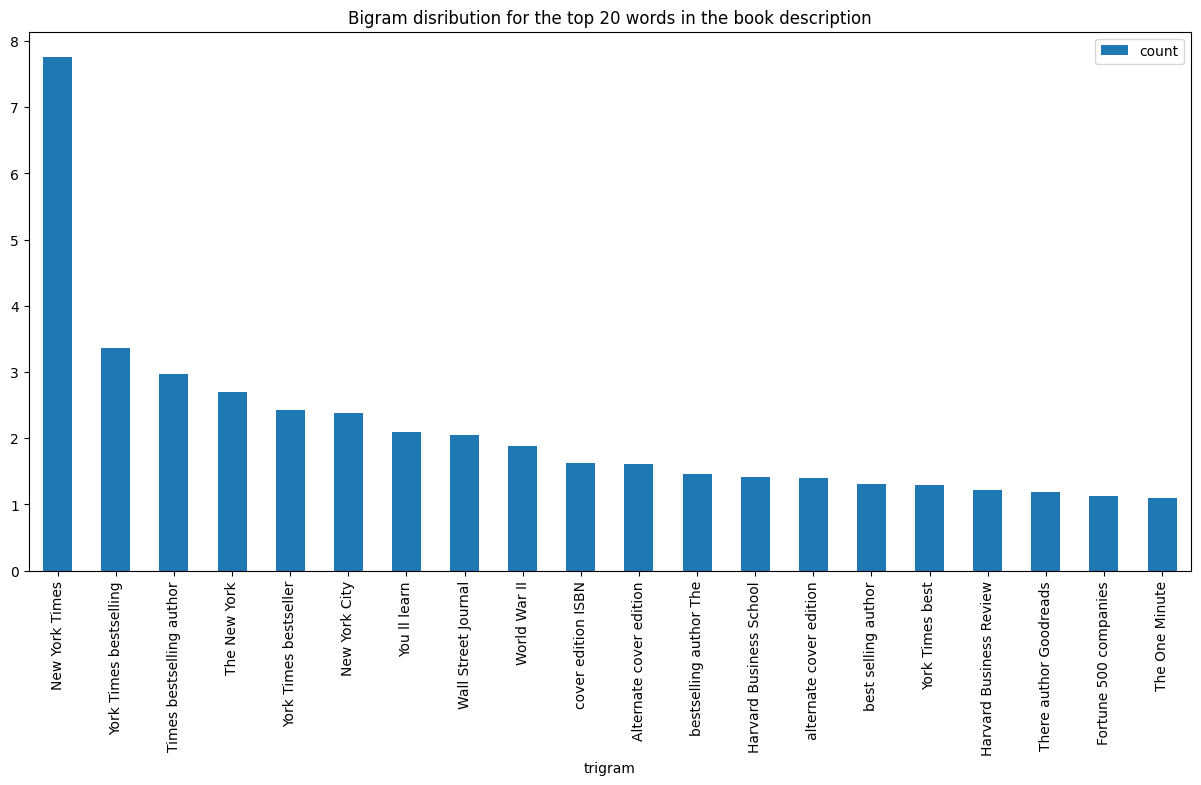

In [34]:
#book summary -> vectors using TF-IDF using Trigram
tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(df['Desc'])
total_words = tfidf_matrix.sum(axis=0)
#word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True)
#20 records
trigram = trigram.head(20)

#trigram distribution
trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Trigram disribution over book descriptions", figsize = (15,7), )